# Exploration phase (**optional**)

In this exploration phase we will visualize some features of your dataset to help you make more informed decisitions in case you want to **adapt the default parameters** to your dataset.

You can always skip this part and go with the default parameters but if you want to have a classifier as efficient as possible you should consider spending five minutes running this analysis.

In [83]:
import os

import matplotlib.pylab as plt
import numpy as np
import pandas as pd
from tqdm import tqdm

import imgclas
from imgclas import paths, config
from imgclas.data_utils import load_image, load_data_splits, augment


CONF = config.get_conf_dict()

# Customize your image folder if needed
# CONF['general']['images_directory'] = '/media/ignacio/Datos/datasets/semillas/datasets'  # absolute path to image_folder

splits_dir = paths.get_splits_dir()

# Load the training data
X_train, y_train = load_data_splits(splits_dir=splits_dir,
                                    im_dir=CONF['general']['images_directory'],
                                    split_name='train')

# Load the validation data
if (CONF['training']['use_validation']) and ('val.txt' in os.listdir(splits_dir)):
    X_val, y_val = load_data_splits(splits_dir=splits_dir,
                                    im_dir=CONF['general']['images_directory'],
                                    split_name='val')
else:
    print('No validation data.')
    X_val, y_val = None, None
    CONF['training']['use_validation'] = False
    
# Load the test data
X_test, y_test = load_data_splits(splits_dir=splits_dir,
                                    im_dir=CONF['general']['images_directory'],
                                    split_name='test')

## 1.1 Distribution of classes
**Relevant parameters:** `use_class_weights`

We can visualize the distributions of the classes to check is the dataset is highly imbalanced.

Max Training: 67.0
Min Training: 34.0
Mean Training: 61.5
Median Training: 67.0


Max Validation: 10.0
Min Validation: 4.0
Mean Validation: 8.833333333333334
Median Validation: 10.0




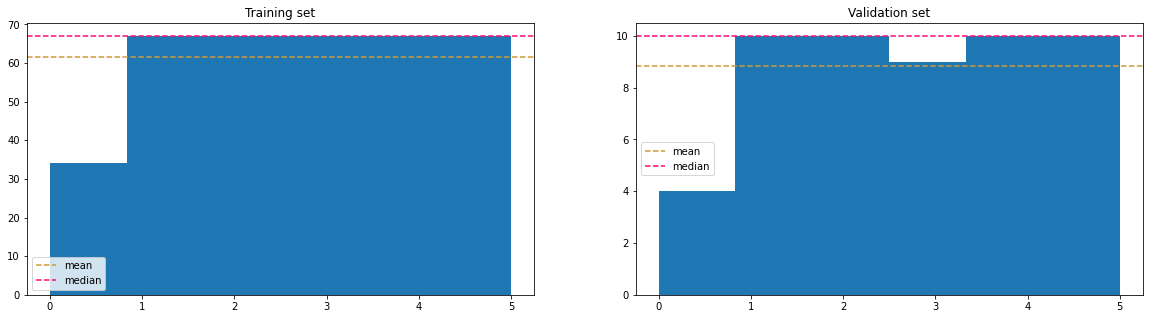

In [2]:
# Define some parameters
log_scale = False
show_names = False

# Plot the histograms
fig, axs = plt.subplots(1, 2, figsize=(20,5))

def plot_hist(ax, y, set_name=''):
    n, bins, patches = ax.hist(y, bins=len(class_names), log=log_scale)
    mean, med = np.mean(n), np.median(n)
    ax.axhline(mean, linestyle= '--', color='#ce9b3b', label='mean')
    ax.axhline(med, linestyle= '--', color='#fc0c70', label='median')
    ax.set_title('{} set'.format(set_name))
    ax.legend()
    if show_names:
        ax.set_xticks(range(len(class_names)))
        ax.set_xticklabels(class_names, rotation='vertical')

    print('Max {}: {}'.format(set_name, np.amax(n)))
    print('Min {}: {}'.format(set_name, np.amin(n)))
    print('Mean {}: {}'.format(set_name, mean))
    print('Median {}: {}'.format(set_name, med))
    print('\n')

plot_hist(axs[0], y_train, set_name='Training')

axs[1].set_title('Validation set')
if y_val is not None:
    plot_hist(axs[1], y_val, set_name='Validation')

So if your dataset is **very** imbalanced you can consider setting the `use_class_weights` to `True` to compensate for this imbalance during the training.

## 1.2 Distribution of image sizes
**Relevant parameters:** `im_size`

We can visualize how the sizes of your images are tipically distributed in case you want to use a bigger image size resolution than the default.

In [3]:
cd ..

/srv/image-classification-tf


In [4]:
# Load all images and retrieve their shapes
height, width = [], []
for img_path in tqdm(X_train):
    img = load_image(img_path)
    w, h, channels = img.shape
    width.append(w)
    height.append(h)

100%|██████████| 369/369 [01:12<00:00,  5.10it/s]


Max Heights: 3000
Min Heights: 3000
Mean Heights: 3000.0
Median Heights: 3000.0
Heights 5th percentile: 3000.0


Max Widths: 4000
Min Widths: 4000
Mean Widths: 4000.0
Median Widths: 4000.0
Widths 5th percentile: 4000.0


Max Combined: 4000
Min Combined: 3000
Mean Combined: 3500.0
Median Combined: 3500.0
Combined 5th percentile: 3000.0




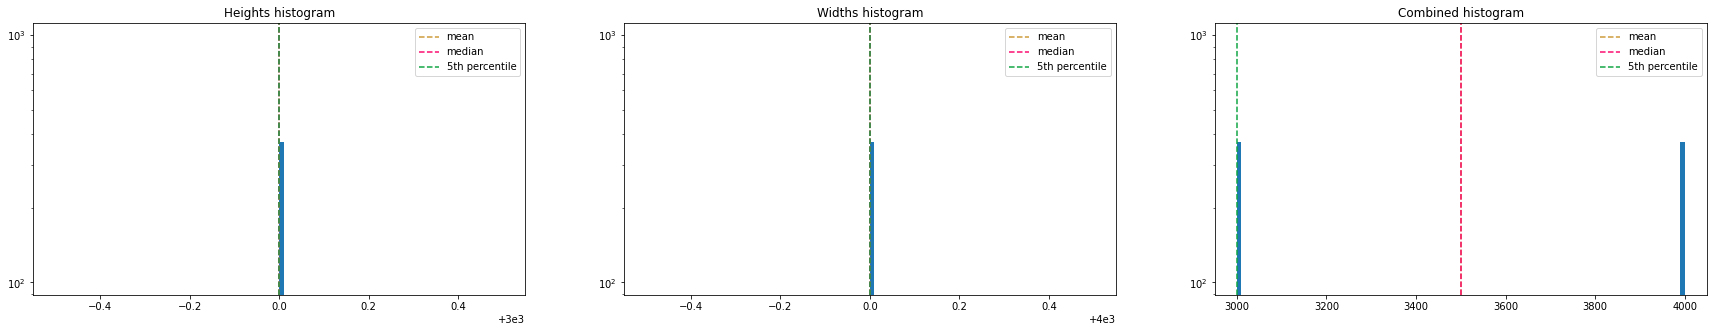

In [5]:
# Define some parameters
bins = 100
log_scale = True
lower_percentile = 5

def plot_hist(ax, values, set_name=''):
    
    # Print some stats
    mean, med, per = np.mean(values), np.median(values), np.percentile(values, lower_percentile)

    print('Max {}: {}'.format(set_name, np.amax(values)))
    print('Min {}: {}'.format(set_name, np.amin(values)))
    print('Mean {}: {:.1f}'.format(set_name, mean))
    print('Median {}: {}'.format(set_name, med))
    print('{} {}th percentile: {}'.format(set_name, lower_percentile, per))
    print('\n')
      
    # Plot the histogram
    ax.hist(values, bins=bins, log=log_scale)
    ax.set_title('{} histogram'.format(set_name))
    ax.axvline(mean, linestyle= '--', color='#ce9b3b', label='mean')
    ax.axvline(med, linestyle= '--', color='#fc0c70', label='median')
    ax.axvline(per, linestyle= '--', color='#0ea541', label='{}th percentile'.format(lower_percentile))
    ax.legend()

    
fig, axs = plt.subplots(1, 3, figsize=(30,5))
axs = axs.flatten()

plot_hist(axs[0], height, set_name='Heights')
plot_hist(axs[1], width, set_name='Widths')
plot_hist(axs[2], height + width, set_name='Combined')

So after examining these plots and stats you can consider adapting the parameter `im_size` to better suit your usecase (maybe to a value in between the `Min combined` and the `Combined 5th percentile`).

When **increasing** this parameter from the default value you have to consider that:
* you keep more details in the image so the accuracy of the model *might* (or might not) increase.
* bigger images size means longer training and inference times
* bigger images means more model parameters. So it is possible to that model becomes too big to be trained on a GPU. 

## 1.3 Data augmentation
**Relevant parameters:** `aug_params`

Let's visualize if the default parameters of the data augmentation suit our dataset (and change them if needed)


    Perform data augmentation on some image using the albumentations package.

    Parameters
    ----------
    im : Numpy array
    params : dict or None
        Contains the data augmentation parameters
        Mandatory keys:
        - h_flip ([0,1] float): probability of performing an horizontal left-right mirroring.
        - v_flip ([0,1] float): probability of performing an vertical up-down mirroring.
        - rot ([0,1] float):  probability of performing a rotation to the image.
        - rot_lim (int):  max degrees of rotation.
        - stretch ([0,1] float):  probability of randomly stretching an image.
        - crop ([0,1] float): randomly take an image crop.
        - zoom ([0,1] float): random zoom applied to crop_size.
            --> Therefore the effective crop size at each iteration will be a
                random number between 1 and crop*(1-zoom). For example:
                  * crop=1, zoom=0: no crop of the image
                  * crop=1, zoom=0.1: random 

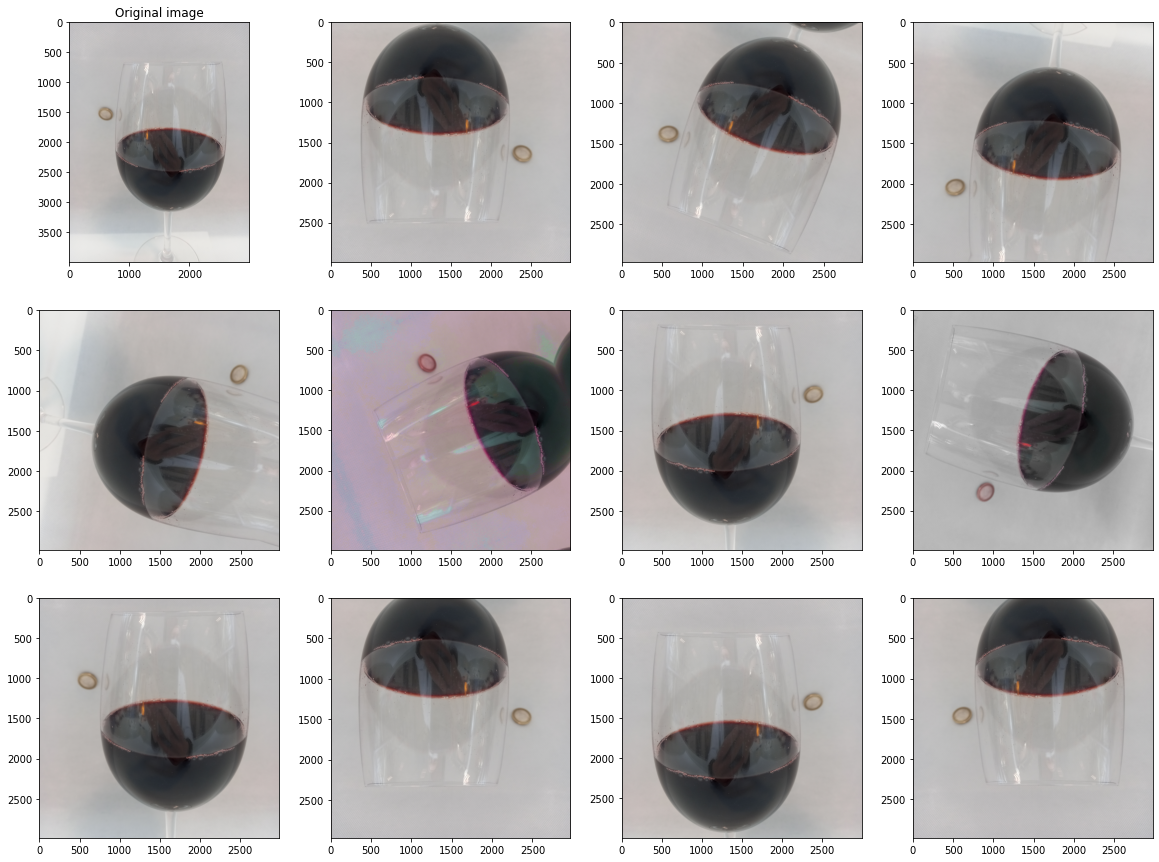

In [6]:
# Select the augmentation type
aug_params = CONF['augmentation']['train_mode'] #you can also try 'test_mode'

# You can also use your custom parameter to try different augmentations
# aug_params = {'h_flip': 0.5,
#               'v_flip': 0.5,
#               'rot': 0.7,
#               'rot_lim': 90,
#               'stretch': 0.,
#               'crop': 1.0,
#               'zoom': 0.2,
#               'blur': 0.3,
#               'pixel_noise': 0.3,
#               'pixel_sat': 0.3,
#               'cutout': 0.5}

print(augment.__doc__)

fig, axs = plt.subplots(3,4, figsize=(20,15))
axs = axs.flatten()

# Plot original image
img = load_image(X_train[0])
axs[0].imshow(np.array(img).astype(np.uint8))
axs[0].set_title('Original image')

# Plot different examples of data augmentation
for i in range(11):
    img_aug = augment(img, params=aug_params)
    axs[i+1].imshow(np.array(img_aug).astype(np.uint8))

In [7]:
aug_params

{'h_flip': 0.5,
 'v_flip': 0.5,
 'rot': 0.5,
 'rot_lim': 90,
 'stretch': 0.0,
 'crop': 1.0,
 'zoom': 0.01,
 'blur': 0.2,
 'pixel_noise': 0.1,
 'pixel_sat': 0.3,
 'cutout': 0.0}